## Simulation of Online Learning

In [42]:
import requests
import math
import json
import csv
from pprint import pprint
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import random
import math
import time
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage.filters import gaussian_filter1d
import re
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize
import bisect 
import pandas as pd

from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax, argmin
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.stats import beta

In [43]:
import argparse
import time
import ray
from ray import air, tune
from ray.air import session
from ray.tune.schedulers import AsyncHyperBandScheduler,PopulationBasedTraining
from ray.tune import run, sample_from
import warnings
warnings.simplefilter('ignore')

from ray.air.checkpoint import Checkpoint
from ray.tune.tune_config import TuneConfig
from ray.air.config import FailureConfig, RunConfig
from ray.tune.tuner import Tuner

from ray.tune.schedulers.pb2 import PB2

## Agents

In [44]:
class UCB1():
    
    def __init__(self, c=1, actions=10):
        
        self.c = c
        self.actions = actions
        
        self.counts = [0 for col in range(self.actions)]
        
        self.values = [0.0 for col in range(self.actions)]
        
        self.action_total_reward = [0.0 for _ in range(self.actions)]
        self.action_avg_reward = [[] for action in range(self.actions)]
        
        return
    
    def max_(self,values):
        max_index = 0
        maxv = values[max_index]
        for i in range(len(values)):
            if values[i] > maxv:
                maxv = values[i]
                max_index = i
        return max_index

    def select_action(self):
        actions = len(self.counts)
        for action in range(actions):
            if self.counts[action] == 0:
                return action
    
        ucb_values = [0.0 for action in range(actions)]
        total_counts = sum(self.counts)
        for action in range(actions):
            bonus =  self.c * (math.sqrt((2 * math.log(total_counts)) / float(self.counts[action])))
            ucb_values[action] = self.values[action] + bonus
        return self.max_(ucb_values)

    def update(self, chosen_act, reward):
        self.counts[chosen_act] = self.counts[chosen_act] + 1
        n = self.counts[chosen_act]
        
#     # Update average/mean value/reward for chosen action
        value = self.values[chosen_act]
        new_value = ((n - 1) / float(n)) * value + (1 / float(n)) * reward
        #new_value2 = value + (1/n * (reward - value))
        self.values[chosen_act] = new_value
        
        self.action_total_reward[chosen_act] += reward
        for a in range(self.actions):
            if self.counts[a]:
                self.action_avg_reward[a].append(self.action_total_reward[a]/self.counts[a])
            else:
                self.action_avg_reward[a].append(0)
        return

     
    
    
class BootstrappedUCB:

    def __init__(self, B=200, delta=0.1, actions = 10):
        self.B = B
        self.delta = delta
        self.actions = actions

        self.counts = np.ones(self.actions)
        self.sum_rewards = np.random.normal(0, 1, self.actions)

    def max_(self, values):
        max_index = 0
        maxv = values[max_index]
        for i in range(len(values)):
            if values[i] > maxv:
                maxv = values[i]
                max_index = i
        return max_index

    def select_action(self):
        means = self.sum_rewards / self.counts
        bootstrapped_quantiles = np.zeros(self.actions)
        for k in range(self.actions):
            bootstrapped_samples = np.random.normal(means[k], 1, (int(self.counts[k]), self.B))
            bootstrapped_quantiles[k] = np.percentile(bootstrapped_samples, 100 * (1 - self.delta))

        confidence_level = 1 / (sum(self.counts) + 1)
        second_order_correction = np.sqrt(np.log(2 / confidence_level) / self.counts)
        ucb_indices = means + bootstrapped_quantiles + second_order_correction

        return self.max_(ucb_indices)

    def update(self, chosen_act, reward):
        self.counts[chosen_act] += 1
        self.sum_rewards[chosen_act] += reward
        
        
        
        
        
        
class ThompsonSamplingUnknownMeanVariance:

    def __init__(self, actions=20, mu_0=0, lambda_0=1, alpha_0=1, beta_0=1):
        self.actions = actions

        # Hyperparameters for the Normal-Gamma prior
        self.mu_0 = mu_0
        self.lambda_0 = lambda_0
        self.alpha_0 = alpha_0
        self.beta_0 = beta_0

        self.counts = np.zeros(self.actions)
        self.sum_x = np.zeros(self.actions)
        self.sum_x_square = np.zeros(self.actions)

    def max_(self, values):
        max_index = 0
        maxv = values[max_index]
        for i in range(len(values)):
            if values[i] > maxv:
                maxv = values[i]
                max_index = i
        return max_index

    def select_action(self):
        samples = np.zeros(self.actions)
        for k in range(self.actions):
            tau_k = np.random.gamma(self.alpha_0 + self.counts[k] / 2, 1 / (self.beta_0 + 0.5 * (self.sum_x_square[k] - (self.sum_x[k] ** 2) / (self.counts[k] + 1))))
            mu_k = np.random.normal(self.sum_x[k] / (self.lambda_0 + self.counts[k]), 1 / np.sqrt(tau_k * (self.lambda_0 + self.counts[k])))
            samples[k] = mu_k
        return self.max_(samples)

    def update(self, chosen_act, reward):
        self.counts[chosen_act] += 1
        self.sum_x[chosen_act] += reward
        self.sum_x_square[chosen_act] += reward ** 2
        

In [45]:
class NoisyEnv:
    def __init__(self, mus, sigmas, noise_std=0.05):
        self.mus = mus
        self.sigmas = sigmas
        self.env_key = 0
        self.noise_std = noise_std

    def sample(self, action):
        mu = self.mus[action]
        sigma = self.sigmas[action]
        reward = np.random.normal(mu, sigma)
        noise = np.random.normal(0, self.noise_std)
        return reward + noise
    def step(self):
        pass
    
    def best_action(self):
        return np.argmin(self.mus)


In [46]:
class Env:
    def __init__(self, mus, sigmas):
        self.mus = mus
        self.sigmas = sigmas
        self.env_key = 0
        
    def sample(self, action):
        mu, sigma = self.mus[action], self.sigmas[action]
        return np.random.normal(mu, sigma)
    
    def step(self):
        pass
    
    def best_action(self):
        return np.argmin(self.mus)
    


## Dynamic Env.

In [47]:
class DynamicEnv:
    def __init__(self, mus_all, sigmas_all, change_every):
        self.mus_all = mus_all
        self.sigmas_all = sigmas_all
        self.change_every = change_every
        self.timestep = 0
        self.reselect_env()
        
    def sample(self, action):
        mu, sigma = self.mus[action], self.sigmas[action]
        return np.random.normal(mu, sigma)
    
    def reselect_env(self):
        new_idx = np.random.randint(0, len(self.mus_all))
        self.env_key = new_idx
        self.mus, self.sigmas = self.mus_all[new_idx], self.sigmas_all[new_idx]
        
    def best_action(self):
        return np.argmin(self.mus)
        
    def step(self):
        self.timestep+=1 
        
        if self.timestep%self.change_every==0:
            self.reselect_env()

## Simulation

In [48]:
def do_run(env, 
           select_action_class,
           n_steps,
            ): 
    selected_actions, rewards, res, Nom_norm, cum_response_time, cum_cost, average_response_time, env_keys, best_chosen = [], [],[],[],[],[],[],[],[]
    for step in range(n_steps):
        
        # select the action 
        action = select_action_class.select_action()
        
        best_action = env.best_action()
        best_action_chosen = action == best_action
        best_chosen.append(best_action_chosen)
        
        env_keys.append(env.env_key)
        delay = env.sample(action)
        reward = 1-delay
        
        selected_actions.append(action)
        rewards.append(reward)
        res.append(delay)
        
        average_response_time.append(sum(res)/len(res))
        cum_response_time.append(sum(res))
        
        select_action_class.update(action, reward)
        
        env.step()
    
    return {"rewards": rewards, 
            "cum_response_time": cum_response_time, 
            "average_response_time": average_response_time, 
            "res": res, 
            "best_chosen" : best_chosen,
            "selected_actions": selected_actions,
            "env_keys": env_keys}
            

## Updated Simulation to increase the c parameter every 1000 time steps

In [49]:
# def do_run(env, 
#            select_action_class,
#            n_steps,
#             ): 
#     selected_actions, rewards, res, Nom_norm, cum_response_time, cum_cost, average_response_time, env_keys, best_chosen = [], [],[],[],[],[],[],[],[]
#     for step in range(n_steps):
#         if step % 1000 == 0 and step > 0:
#             select_action_class.c *= 1.1
            
#         # select the action 
#         action = select_action_class.select_action()
        
#         best_action = env.best_action()
#         best_action_chosen = action == best_action
#         best_chosen.append(best_action_chosen)
        
#         env_keys.append(env.env_key)
#         delay = env.sample(action)
#         reward = 1-delay
        
#         selected_actions.append(action)
#         rewards.append(reward)
#         res.append(delay)
        
#         average_response_time.append(sum(res)/len(res))
#         cum_response_time.append(sum(res))
        
#         select_action_class.update(action, reward)
        
#         env.step()
        
        
        
#     return {"rewards": rewards, 
#             "cum_response_time": cum_response_time, 
#             "average_response_time": average_response_time, 
#             "res": res, 
#             "best_chosen" : best_chosen,
#             "selected_actions": selected_actions,
#             "env_keys": env_keys}
            

In [50]:
# PB2 objective function
def easy_objective_pb2(config):
    # Hyperparameters
    c = config["c"]

    for step in range(config["steps"]):
        # Iterative training function - can be an arbitrary training procedure
        #intermediate_score = resp_time(step, c)
        intermediate_score = c
        # Feed the score back back to Tune.
        session.report({"iterations": step, "mean_loss": intermediate_score})


def initialise_PB_point():
    perturbation_interval = 5
    pbt = PB2(
        time_attr="training_iteration",
        perturbation_interval=perturbation_interval,
        hyperparam_bounds={
            # hyperparameter bounds.
            "c": [0.0001, 0.02],
        },
    )

    tuner = tune.Tuner(
        easy_objective_pb2,
        run_config=air.RunConfig(
            name="pbt_test",
            verbose=0,
            stop={
                "training_iteration": 15,
            },
            failure_config=air.FailureConfig(
                fail_fast=True,
            ),
        ),
        tune_config=tune.TuneConfig(
            scheduler=pbt,
            metric="mean_loss",
            mode="min",
            num_samples=6,
        ),
        param_space={
            "steps": 10,
            "c": sample_from(
                    lambda spec: np.random.uniform(0.1, 0.5)),
            "some_other_factor": 1,
            # This parameter is not perturbed and is used to determine
            # checkpoint frequency. We set checkpoints and perturbations
            # to happen at the same frequency.
            "checkpoint_interval": perturbation_interval,
        },
    )

    pb2_results = tuner.fit()

    points = list(pb2_results.get_best_result().config.values())[1]
    
    return [points]
    
def InitialiseSample(size):
    return np.random.uniform(low=0.0, high=0.5, size=size)

def InitialisePB2(size):
    points = []
    for i in range(size):
        points += initialise_PB_point()
    return points


## Some evaluation metrics

In [51]:
## metric1 - average response time at the end across all points
def average_response_time_end_all_points(score_history):
    return np.mean(score_history[-1])

## metric2 - average response time of best point at end
def average_response_time_best_point_final_step(score_history):
    return min(score_history[-1])


## metric3 - average response time of all points over all steps
def average_response_time_all_points_all_steps(score_history):
    return np.concatenate(score_history).mean()

metrics = {"average_response_time_end_all_points": average_response_time_end_all_points,
           "average_response_time_best_point_final_step": average_response_time_best_point_final_step,
           "average_response_time_all_points_all_steps": average_response_time_all_points_all_steps,
          }

## Gaussian_process

In [52]:
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [53]:
def select_points_GP(point_set, point_scores, noise_level=0.5):
    '''
    Gaussian_process, accepts a set of points, and a set of scores, 
    and returns a new set of points
    '''
    kernel = RBF() + WhiteKernel(noise_level=noise_level)
    model1 = GaussianProcessRegressor(kernel=kernel)

    # fit the model
    model1.fit(point_set.reshape(-1, 1), point_scores)

    
    new_points = np.random.uniform(low=0.0, high=0.5, size=50)
    
    original_points_predictions, _ = model1.predict(point_set.reshape(-1, 1), return_std=True)
    new_points_predictions, std = model1.predict(new_points.reshape(-1, 1), return_std=True)

    best = min(original_points_predictions)
    mu = new_points_predictions

    z = (mu - best) / (std+1E-9)
    probs = (mu - best) * norm.cdf(z) + (std+1E-9) * norm.pdf(z)

    ind_best_point = np.argmin(probs)
    new_point = new_points[ind_best_point]

    return np.array([new_point])


## New idea of Gaussian_process

In [54]:
global_counter = 0
def select_points_GP_x_iteration(point_set, point_scores, noise_level=0.5, x_iteration = 5):
    global global_counter
    kernel = RBF() + WhiteKernel(noise_level = noise_level)
    model1 = GaussianProcessRegressor(kernel=kernel)
    model1.fit(point_set.reshape(-1,1), point_scores)
    
    new_points = np.random.uniform(low = 0.0, high = 0.5, size = 50)
    original_points_predictions, _ = model1.predict(point_set.reshape(-1,1), return_std = True)
    new_points_predictions, std = model1.predict(new_points.reshape(-1,1), return_std = True)
    new_points2 = np.random.uniform(low=1.1, high=2.1, size=50)
    best = min(original_points_predictions)
    mu = new_points_predictions
    z = (mu - best) / (std+1E-9)
    probs = (mu - best) * norm.cdf(z) + (std+1E-9) * norm.pdf(z)
    
    if global_counter % x_iteration == 0:
        new_point = np.random.choice(new_points2)
        
        
    else:
        ind_best_point = np.argmin(probs)
        new_point = new_points[ind_best_point]
        
        
    global_counter +=1
    
    return np.array([new_point])
        

In [55]:
import random

In [56]:
def select_points_GP_with_random_chance(point_set, point_scores, noise_level=0.5, random_chance =0.2):
    kernel = RBF() + WhiteKernel(noise_level=noise_level)
    model1 = GaussianProcessRegressor(kernel=kernel)
    
    new_points = np.random.uniform(low = 0.0, high = 0.5, size = 50)
    original_points_predictions, _ = model1.predict(point_set.reshape(-1,1), return_std = True)
    new_points_predictions, std = model1.predict(new_points.reshape(-1,1), return_std = True)
    
    new_points2 = np.random.uniform(low=1.1, high=2.1, size=50)
    
    best = min(original_points_predictions)
    mu = new_points_predictions
    z = (mu - best) / (std+1E-9)
    probs = (mu - best) * norm.cdf(z) + (std+1E-9) * norm.pdf(z)
    
    if random.random() < random_chance:
        new_point = np.random.choice(new_points2)
        
    else:
        ind_best_point = np.argmin(probs)
        new_point = new_points[ind_best_point]
        
    return np.array([new_point])
    

## Main Methods

In [57]:
def remove_none(point_set, all_points_scores):
    return point_set, all_points_scores

def remove_oldest_point(point_set, all_points_scores):
    return point_set[1:], all_points_scores[1:]



## re-evaluated every re_evaluation_period iterations

In [58]:
def keep_uniform_and_top_points_re_evaluate(point_set, all_points_scores, initial_points=None, uniform_fraction=0.5, re_evaluation_period=20):
    if initial_points is None:
        
        initial_points = np.random.uniform(low=0.0, high=0.5, size=20)
        
    threshold_index = int(len(initial_points) * 0.8)

    if threshold_index == 0:
        return point_set, all_points_scores

    # Calculate the uniform spacing
    spacing = max(1, len(point_set) // threshold_index)

    # Choose points with uniform spacing and top-performing points
    n_uniform_points = int(threshold_index * uniform_fraction)
    n_top_points = threshold_index - n_uniform_points

    uniform_indices = np.arange(0, len(point_set), spacing)[:n_uniform_points]
    top_indices = np.argsort(all_points_scores)[:n_top_points]
    selected_indices = np.union1d(uniform_indices, top_indices)

    selected_point_set = point_set[selected_indices]

    # Re-evaluate the selected points and update their average response time 
    if len(point_set) % re_evaluation_period == 0:
        new_selected_scores = []
        for point in selected_point_set:
            response_times = []
            for trial in range(1):
                env = Env(mus, sigmas)
                select_action_class = UCB1(actions=num_actions, c=point)

                results = do_run(env, select_action_class, n_steps=4000)
                response_times.append(results["average_response_time"])

            new_selected_scores.append(np.mean(response_times))

        # The new scores
        all_points_scores[selected_indices] = new_selected_scores

    # Remove non_pillar points
    point_set = np.delete(point_set, np.setdiff1d(np.arange(len(point_set)), selected_indices))
    all_points_scores = np.delete(all_points_scores, np.setdiff1d(np.arange(len(all_points_scores)), selected_indices))

    return point_set, all_points_scores


## Main methods testing

In [59]:
add_1_remove_none = (select_points_GP_x_iteration, remove_none)
add_1_remove_oldest = (select_points_GP_x_iteration, remove_oldest_point)
PB2_method = (select_points_GP_x_iteration, remove_none)
add_1_keep_uniform_top = (select_points_GP_x_iteration,keep_uniform_and_top_points_re_evaluate)

In [60]:
def test_method(mus_all, sigmas_all, method, start_size=20, init_method=None, change_every=1000, verbose=True, plot=True):
    
    n_steps = 4000
    
    if len(mus_all.shape) == 1:
        mus_all = np.array([mus_all])
        sigmas_all = np.array([sigmas_all])
        change_every = n_steps + 1
        #print("mus_all.shape: ", mus_all.shape)
    
    if not init_method:
        #new_points = np.random.beta(10, 100, size=start_size)
        new_points = np.random.uniform(low=0.0, high=0.5, size=start_size)
        

    else:
        new_points = init_method(size=start_size)
    
    optimisation_steps = 50

    
    add_points_function    = method[0]
    remove_points_function = method[1]
        
    point_history = []
    score_history = []
    best_chosen_history = []
    all_points = np.array([])
    all_points_scores = np.array([])
    
    start = time.time()
    
    if len(mus_all.shape)==1:
        num_actions = mus_all.shape[0]
    else:
        num_actions = mus_all.shape[1]
        
    for optimisation_step in tqdm(range(optimisation_steps)):
        new_point_scores = []
        best_chosen_step = []
        avg_step =[]
        for point in new_points:
            
            response_times = []
            best_chosen = []
            for trial in range(5):
                if len(mus_all.shape)==1:
                    env = Env(mus_all, sigmas_all)
                    #env = NoisyEnv(mus, sigmas, noise_std=0.05)
                else:
                    env = DynamicEnv(mus_all, sigmas_all, change_every=change_every)
                
                
                select_action_class = UCB1(actions = num_actions, c=point)

                results = do_run(env, 
                                 select_action_class,
                                 n_steps=n_steps)
                response_times.append(results["average_response_time"])
                best_chosen.append(results["best_chosen"])
            new_point_scores.append(np.mean(response_times))
            avg_step.append(response_times)
            best_chosen_step.append(best_chosen)
            
        best_chosen_history.append(best_chosen_step)
        
        point_history.append(new_points)
        
        score_history.append(new_point_scores)

        all_points = np.concatenate((all_points, new_points))

        all_points_scores = np.concatenate((all_points_scores, new_point_scores))

        # add function
        new_points = add_points_function(all_points, all_points_scores)

        # methods
        if remove_points_function:
            all_points, all_points_scores = remove_points_function(all_points, all_points_scores)
    
    run_time = time.time() - start 
    avg_step= np.array(avg_step)
    if plot:
        plt.plot(avg_step.mean(axis=0).mean(axis=0))
    scores = {}
    if verbose:
        print(f"select_new_points: {method[0].__name__} - remove_points: {method[1].__name__}")
        print(f"run_time: {run_time}")
    scores["run_time"] =  run_time
    for metric_name, metric_func in metrics.items():
        score = metric_func(score_history)
        scores[metric_name] = score
        if verbose:
            print(f"{metric_name}: {score}")
        
    return scores, avg_step.mean(axis=0), best_chosen_step



## Workloads

In [61]:
n_env = 1
num_actions = 60
# Generate means with greater differences
mus = (np.random.randint(low=50, high=120, size=(n_env, num_actions)) / 100).flatten()
# Generate sigmas with higher variance
sigmas = (np.random.randint(low=40, high=80, size=(n_env, num_actions)) / 100).flatten()


In [62]:
num_actions = 60
n_env = 1

mus_group1 = np.random.normal(loc=50, scale=2, size=(n_env, num_actions // 3)).flatten()
mus_group2 = np.random.normal(loc=60, scale=2, size=(n_env, num_actions // 3)).flatten()
mus_group3 = np.random.normal(loc=70, scale=2, size=(n_env, num_actions - (2 * num_actions // 3))).flatten()
mus = np.hstack((mus_group1, mus_group2, mus_group3))

sigmas_group1 = np.random.uniform(low=8, high=10, size=(n_env, num_actions // 3)).flatten()
sigmas_group2 = np.random.uniform(low=10, high=12, size=(n_env, num_actions // 3)).flatten()
sigmas_group3 = np.random.uniform(low=12, high=14, size=(n_env, num_actions - (2 * num_actions // 3))).flatten()
sigmas = np.hstack((sigmas_group1, sigmas_group2, sigmas_group3))

# one action to be dominant
dominant_action = np.random.randint(num_actions)
mus[dominant_action] = 40
sigmas[dominant_action] = 12


In [63]:
# n_env = 1
# num_actions = 40 

# # Use a uniform distribution to generate the means and standard deviations
# mus = (np.random.uniform(low=1, high=1000, size=(n_env,num_actions))/100).flatten()
# sigmas = (np.random.uniform(low=1, high=1000, size=(n_env,num_actions))/100).flatten()



In [64]:
# n_env = 1
# num_actions = 200  

# # Generate means close together
# mus = (np.random.uniform(low=40, high=60, size=(n_env,num_actions))/100).flatten()

# # Use high variance
# sigmas = (np.random.uniform(low=40, high=60, size=(n_env,num_actions))/100).flatten()


## Plotting all methods

In [65]:
def test_method_n_times(n, **kwargs):
    results = []
    response_times_means = []
    best_chosen_step_prob = []
    for i in range(n):
        result, response_times_mean,best_chosen_step = test_method(**kwargs)
        results.append(result)
        response_times_means.append(response_times_mean)
        best_chosen_step_prob.append(best_chosen_step)
    mean_response_times = np.array(response_times_means)
    #best_action_plot = np.array(best_chosen_step_prob).mean(axis=0)
    best_action_plot = np.array(best_chosen_step_prob)

    # plt.figure()
    # plt.title("Mean response time")
    # plt.plot(mean_response_times.mean(axis=0))
    # plt.figure()
    # plt.title("probability")
    # plt.plot(best_action_plot.mean(axis=0))
    arrays = {key:[] for key in result.keys()}
    for item in results:
        for key, value in item.items():
            arrays[key].append(value)
    return {key:np.mean(item) for key, item in arrays.items()},mean_response_times,best_action_plot

## Update UCB

100%|██████████| 50/50 [02:27<00:00,  2.96s/it]


select_new_points: select_points_GP_x_iteration - remove_points: remove_none
run_time: 147.91731119155884
average_response_time_end_all_points: 41.72578350362098
average_response_time_best_point_final_step: 41.72578350362098
average_response_time_all_points_all_steps: 43.78471571461864


100%|██████████| 50/50 [02:31<00:00,  3.03s/it]


select_new_points: select_points_GP_x_iteration - remove_points: remove_none
run_time: 151.48173069953918
average_response_time_end_all_points: 44.31213659831868
average_response_time_best_point_final_step: 44.31213659831868
average_response_time_all_points_all_steps: 44.224314878151155


100%|██████████| 50/50 [02:31<00:00,  3.03s/it]

select_new_points: select_points_GP_x_iteration - remove_points: remove_none
run_time: 151.25376224517822
average_response_time_end_all_points: 43.00265812698408
average_response_time_best_point_final_step: 43.00265812698408
average_response_time_all_points_all_steps: 43.961824955366154


{'run_time': 150.21760137875876,
 'average_response_time_end_all_points': 43.01352607630792,
 'average_response_time_best_point_final_step': 43.01352607630792,
 'average_response_time_all_points_all_steps': 43.99028518271198}

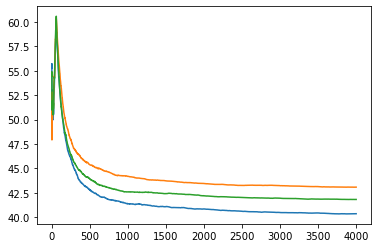

In [66]:
means_IL,mean_r_IL, best_c_IL = test_method_n_times(3, 
                    mus_all=mus, 
                    sigmas_all=sigmas, 
                    init_method=InitialiseSample,
                    method=add_1_remove_none, 
                    verbose=True)
means_IL

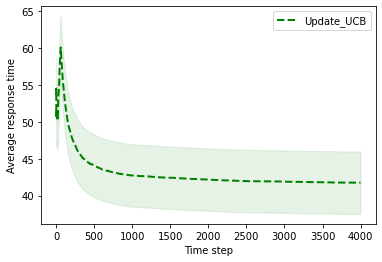

In [67]:
CI_I= 1.96 * np.std(mean_r_IL)/np.sqrt(len(mean_r_IL))
update_ucb = mean_r_IL.mean(axis=0).mean(axis=0)
plt.plot(update_ucb,label='Update_UCB' ,lw=2,ls='--', color= 'g')
plt.fill_between(np.arange(len(update_ucb)), (update_ucb - CI_I),(update_ucb + CI_I),color= 'g', alpha=0.1 )

plt.xlabel("Time step")
plt.ylabel("Average response time")
#plt.title("UCB1 Simulation")
#plt.xlim([-10,250])
plt.legend()
plt.show()

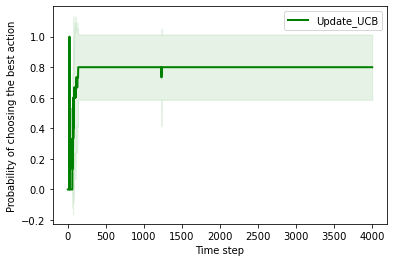

In [68]:
mean_IL = best_c_IL.mean(axis=0).mean(axis=0).mean(axis=0)
std_dev_IL = best_c_IL.std(axis=0).mean(axis=0).mean(axis=0)

# Calculate the 95% confidence interval
conf_interval_IL = 1.96 * std_dev_IL / np.sqrt(best_c_IL.shape[0])
plt.plot(mean_IL, label='Update_UCB' ,lw=2,ls='-', color= 'g')
plt.fill_between(range(len(mean_IL)), (mean_IL-conf_interval_IL), (mean_IL+conf_interval_IL), color='g', alpha=.1)
plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()

## Moving average

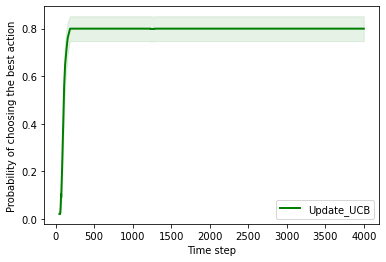

In [69]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

window_size = 50  # adjust this to your needs

# Apply moving average
mean_smooth_IL = moving_average(mean_IL, window_size)
std_dev_smooth_IL = moving_average(std_dev_IL, window_size)

# Calculate the 95% confidence interval for smoothed data
conf_interval_smooth_IL = 1.96 * std_dev_smooth_IL / np.sqrt(window_size)

# Adjust x-values for the smoothed data 
x_values_smooth_IL = range(window_size - 1, len(mean_IL))

# Plot the mean and the confidence interval
plt.plot(x_values_smooth_IL, mean_smooth_IL, label='Update_UCB' ,lw=2,ls='-', color= 'g')
plt.fill_between(x_values_smooth_IL, (mean_smooth_IL-conf_interval_smooth_IL), (mean_smooth_IL+conf_interval_smooth_IL), color='g', alpha=.1)
plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()


## Discard UCB

100%|██████████| 50/50 [02:30<00:00,  3.00s/it]


select_new_points: select_points_GP_x_iteration - remove_points: remove_oldest_point
run_time: 150.0382113456726
average_response_time_end_all_points: 44.708362998753884
average_response_time_best_point_final_step: 44.708362998753884
average_response_time_all_points_all_steps: 44.438215026865365


100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


select_new_points: select_points_GP_x_iteration - remove_points: remove_oldest_point
run_time: 149.73218870162964
average_response_time_end_all_points: 46.06274359207898
average_response_time_best_point_final_step: 46.06274359207898
average_response_time_all_points_all_steps: 43.68098169518842


100%|██████████| 50/50 [02:30<00:00,  3.00s/it]

select_new_points: select_points_GP_x_iteration - remove_points: remove_oldest_point
run_time: 150.04830074310303
average_response_time_end_all_points: 44.93124119409182
average_response_time_best_point_final_step: 44.93124119409182
average_response_time_all_points_all_steps: 43.93560547867455


{'run_time': 149.9395669301351,
 'average_response_time_end_all_points': 45.23411592830823,
 'average_response_time_best_point_final_step': 45.23411592830823,
 'average_response_time_all_points_all_steps': 44.018267400242785}

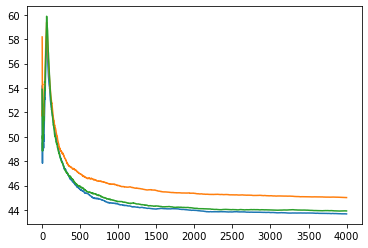

In [70]:
means_DF,mean_r_DF, best_c_DF = test_method_n_times(3, 
                    mus_all=mus, 
                    sigmas_all=sigmas, 
                    init_method=InitialiseSample,
                    method=add_1_remove_oldest, 
                    verbose=True)
means_DF

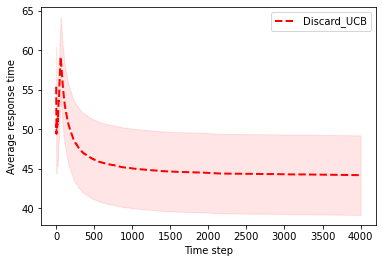

In [71]:
CI_D= 1.96 * np.std(mean_r_DF)/np.sqrt(len(mean_r_DF))
discard_ucb = mean_r_DF.mean(axis=0).mean(axis=0)
plt.plot(discard_ucb,label='Discard_UCB' ,lw=2,ls='--', color= 'r')
plt.fill_between(np.arange(len(discard_ucb)), (discard_ucb - CI_D),(discard_ucb + CI_D),color= 'r', alpha=0.1 )
plt.xlabel("Time step")
plt.ylabel("Average response time")
#plt.title("UCB1 Simulation")
plt.legend()
plt.show()

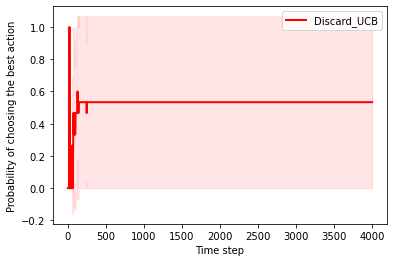

In [72]:
mean_DF = best_c_DF.mean(axis=0).mean(axis=0).mean(axis=0)
std_dev_DF = best_c_DF.std(axis=0).mean(axis=0).mean(axis=0)

# Calculate the 95% confidence interval
conf_interval_DF = 1.96 * std_dev_DF / np.sqrt(best_c_DF.shape[0])

# Plot the mean and the confidence interval
plt.plot(mean_DF, label='Discard_UCB' ,lw=2,ls='-', color= 'r')
plt.fill_between(range(len(mean_DF)), (mean_DF-conf_interval_DF), (mean_DF+conf_interval_DF), color='r', alpha=.1)
plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()



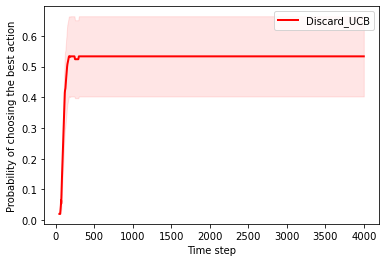

In [73]:
# Apply moving average
mean_smooth_DF = moving_average(mean_DF, window_size)
std_dev_smooth_DF = moving_average(std_dev_DF, window_size)

# Calculate the 95% confidence interval for smoothed data
conf_interval_smooth_DF = 1.96 * std_dev_smooth_DF / np.sqrt(window_size)

x_values_smooth_DF = range(window_size - 1, len(mean_DF))

# Plot the mean and the confidence interval
plt.plot(x_values_smooth_DF, mean_smooth_DF, label='Discard_UCB' ,lw=2,ls='-', color= 'r')
plt.fill_between(x_values_smooth_DF, (mean_smooth_DF-conf_interval_smooth_DF), (mean_smooth_DF+conf_interval_smooth_DF), color='r', alpha=.1)

plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()



## Pillar points

100%|██████████| 50/50 [02:40<00:00,  3.22s/it]


select_new_points: select_points_GP_x_iteration - remove_points: keep_uniform_and_top_points_re_evaluate
run_time: 160.90402626991272
average_response_time_end_all_points: 44.79390300680756
average_response_time_best_point_final_step: 44.79390300680756
average_response_time_all_points_all_steps: 43.66479844105289


100%|██████████| 50/50 [02:37<00:00,  3.15s/it]


select_new_points: select_points_GP_x_iteration - remove_points: keep_uniform_and_top_points_re_evaluate
run_time: 157.36780977249146
average_response_time_end_all_points: 46.22772204058475
average_response_time_best_point_final_step: 46.22772204058475
average_response_time_all_points_all_steps: 43.79695519737875


100%|██████████| 50/50 [02:34<00:00,  3.10s/it]

select_new_points: select_points_GP_x_iteration - remove_points: keep_uniform_and_top_points_re_evaluate
run_time: 154.81841278076172
average_response_time_end_all_points: 41.61740851946218
average_response_time_best_point_final_step: 41.61740851946218
average_response_time_all_points_all_steps: 43.97832761540476


{'run_time': 157.69674960772196,
 'average_response_time_end_all_points': 44.2130111889515,
 'average_response_time_best_point_final_step': 44.2130111889515,
 'average_response_time_all_points_all_steps': 43.81336041794547}

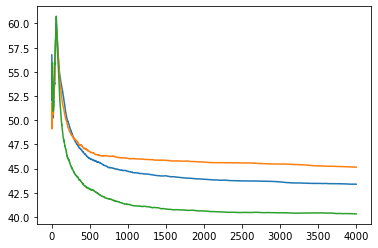

In [74]:
means_pillar,mean_r_pillar, best_c_pillar = test_method_n_times(3, 
                    mus_all=mus, 
                    sigmas_all=sigmas, 
                    init_method=InitialiseSample,
                    method=add_1_keep_uniform_top, 
                    verbose=True)
means_pillar

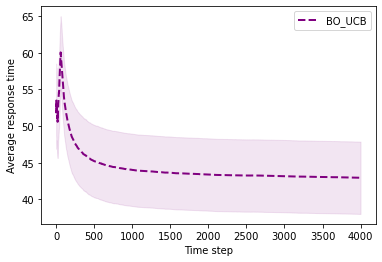

In [75]:
CI_P= 1.96 * np.std(mean_r_pillar)/np.sqrt(len(mean_r_pillar))
BO_ucb = mean_r_pillar.mean(axis=0).mean(axis=0)
plt.plot(BO_ucb,label='BO_UCB' ,lw=2,ls='--', color= 'purple')
plt.fill_between(np.arange(len(BO_ucb)), (BO_ucb - CI_P),(BO_ucb + CI_P),color= 'purple', alpha=0.1 )
plt.xlabel("Time step")
plt.ylabel("Average response time")
#plt.title("UCB1 Simulation")
plt.legend()
plt.show()

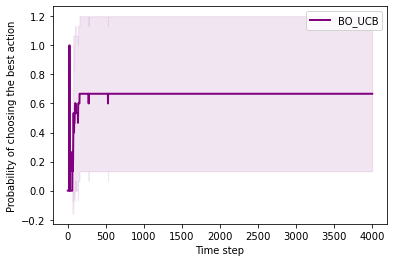

In [76]:
mean_P = best_c_pillar.mean(axis=0).mean(axis=0).mean(axis=0)
std_dev_P = best_c_pillar.std(axis=0).mean(axis=0).mean(axis=0)

# Calculate the 95% confidence interval
conf_interval_P = 1.96 * std_dev_P / np.sqrt(best_c_pillar.shape[0])

# Plot the mean and the confidence interval
plt.plot(mean_P, label='BO_UCB' ,lw=2,ls='-', color= 'purple')
plt.fill_between(range(len(mean_P)), (mean_P-conf_interval_P), (mean_P+conf_interval_P), color='purple', alpha=.1)
plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()


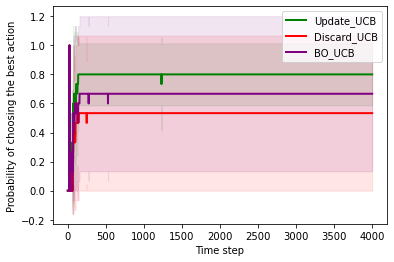

In [77]:
plt.plot(mean_IL, label='Update_UCB' ,lw=2,ls='-', color= 'g')
plt.fill_between(range(len(mean_IL)), (mean_IL-conf_interval_IL), (mean_IL+conf_interval_IL), color='g', alpha=.1)

plt.plot(mean_DF, label='Discard_UCB' ,lw=2,ls='-', color= 'r')
plt.fill_between(range(len(mean_DF)), (mean_DF-conf_interval_DF), (mean_DF+conf_interval_DF), color='r', alpha=.1)

plt.plot(mean_P, label='BO_UCB' ,lw=2,ls='-', color= 'purple')
plt.fill_between(range(len(mean_P)), (mean_P-conf_interval_P), (mean_P+conf_interval_P), color='purple', alpha=.1)
plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()

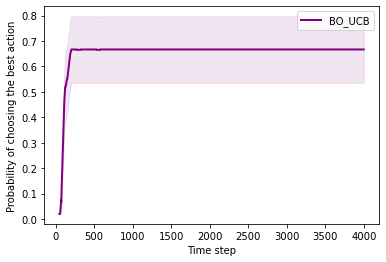

In [78]:
# Applying moving average
mean_smooth_P = moving_average(mean_P, window_size)
std_dev_smooth_P = moving_average(std_dev_P, window_size)

# Calculate the 95% confidence interval for smoothed data
conf_interval_smooth_P = 1.96 * std_dev_smooth_P / np.sqrt(window_size)

x_values_smooth_P = range(window_size - 1, len(mean_P))

# Plot the mean and the confidence interval
plt.plot(x_values_smooth_P, mean_smooth_P, label='BO_UCB' ,lw=2,ls='-', color= 'purple')
plt.fill_between(x_values_smooth_P, (mean_smooth_P-conf_interval_smooth_P), (mean_smooth_P+conf_interval_smooth_P), color='purple', alpha=.1)


plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()

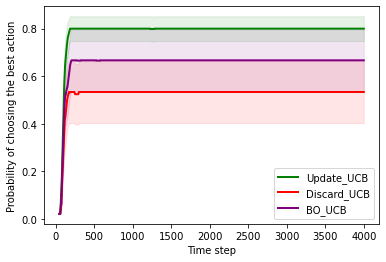

In [79]:
# Plot the mean and the confidence interval
plt.plot(x_values_smooth_IL, mean_smooth_IL, label='Update_UCB' ,lw=2,ls='-', color= 'g')
plt.fill_between(x_values_smooth_IL, (mean_smooth_IL-conf_interval_smooth_IL), (mean_smooth_IL+conf_interval_smooth_IL), color='g', alpha=.1)
plt.plot(x_values_smooth_DF, mean_smooth_DF, label='Discard_UCB' ,lw=2,ls='-', color= 'r')
plt.fill_between(x_values_smooth_DF, (mean_smooth_DF-conf_interval_smooth_DF), (mean_smooth_DF+conf_interval_smooth_DF), color='r', alpha=.1)
plt.plot(x_values_smooth_P, mean_smooth_P, label='BO_UCB' ,lw=2,ls='-', color= 'purple')
plt.fill_between(x_values_smooth_P, (mean_smooth_P-conf_interval_smooth_P), (mean_smooth_P+conf_interval_smooth_P), color='purple', alpha=.1)

plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()


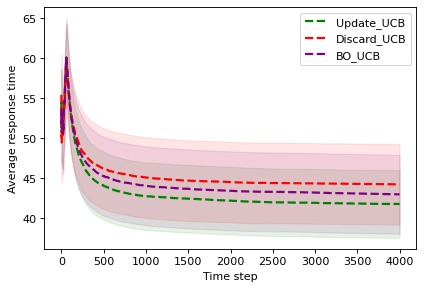

In [80]:
plt.figure(1,dpi=80)
plt.plot(update_ucb,label='Update_UCB' ,lw=2,ls='--', color= 'g')
plt.fill_between(np.arange(len(update_ucb)), (update_ucb - CI_I),(update_ucb + CI_I),color= 'g', alpha=0.1 )
plt.plot(discard_ucb,label='Discard_UCB' ,lw=2,ls='--', color= 'r')
plt.fill_between(np.arange(len(discard_ucb)), (discard_ucb - CI_D),(discard_ucb + CI_D),color= 'r', alpha=0.1 )
plt.plot(BO_ucb,label='BO_UCB' ,lw=2,ls='--', color= 'purple')
plt.fill_between(np.arange(len(BO_ucb)), (BO_ucb - CI_P),(BO_ucb + CI_P),color= 'purple', alpha=0.1 )
plt.xlabel("Time step")
plt.ylabel("Average response time")
#plt.title("UCB1 Simulation")
#plt.ylim([40,55])
plt.legend()
plt.show()

## PB2

2023-06-26 16:44:33,081	INFO pbt.py:646 -- [pbt]: no checkpoint for trial. Skip exploit for Trial easy_objective_pb2_5336a_00001
2023-06-26 16:44:33,635	INFO pbt.py:804 -- 

[PB2] [Exploit] Cloning trial 5336a_00003 (score = -0.240019) into trial 5336a_00005 (score = -0.464539)

2023-06-26 16:44:33,647	INFO pbt.py:831 -- 

[PB2] [Explore] Perturbed the hyperparameter config of trial5336a_00005:
c : 0.24001905684042596 -----> 0.24001905684042596

100%|██████████| 50/50 [02:57<00:00,  3.56s/it]

select_new_points: select_points_GP_x_iteration - remove_points: remove_none
run_time: 177.84076118469238
average_response_time_end_all_points: 44.681890786275154
average_response_time_best_point_final_step: 44.681890786275154
average_response_time_all_points_all_steps: 43.77059123144217


{'run_time': 166.28893947601318,
 'average_response_time_end_all_points': 44.574507952665016,
 'average_response_time_best_point_final_step': 44.574507952665016,
 'average_response_time_all_points_all_steps': 43.82310627572951}

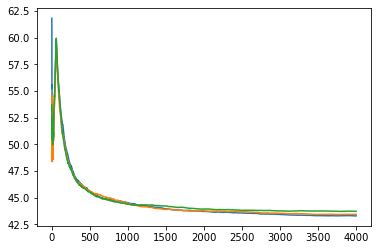

In [81]:
m4,response_times_mean_pb2, P_best_PB2 = test_method_n_times(3,
                                          mus_all=mus,
                                          sigmas_all=sigmas,
                                          init_method=InitialisePB2,
                                          method=PB2_method,
                                          verbose=True)
m4

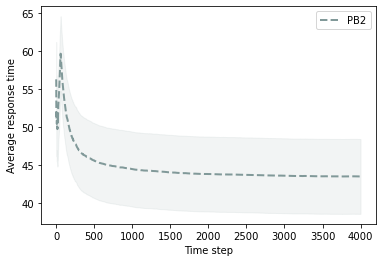

In [82]:
CI_PB2= 1.96 * np.std(response_times_mean_pb2)/np.sqrt(len(response_times_mean_pb2))
PB2_m = response_times_mean_pb2.mean(axis=0).mean(axis=0)
plt.plot(PB2_m,label='PB2' ,lw=2,ls='--', color= '#819999')
plt.fill_between(np.arange(len(PB2_m)), (PB2_m - CI_PB2),(PB2_m + CI_PB2),color= '#819999', alpha=0.1 )
plt.xlabel("Time step")
plt.ylabel("Average response time")
#plt.title("UCB1 Simulation")
plt.legend()
plt.show()

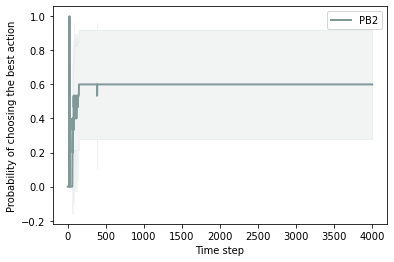

In [83]:
mean_PB2 = P_best_PB2.mean(axis=0).mean(axis=0).mean(axis=0)
std_dev_PB2 = P_best_PB2.std(axis=0).mean(axis=0).mean(axis=0)

# Calculate the 95% confidence interval
conf_interval_PB2 = 1.96 * std_dev_PB2 / np.sqrt(P_best_PB2.shape[0])

# Plot the mean and the confidence interval
plt.plot(mean_PB2, label='PB2' ,lw=2,ls='-', color= '#819999')
plt.fill_between(range(len(mean_PB2)), (mean_PB2-conf_interval_PB2), (mean_PB2+conf_interval_PB2), color='#819999', alpha=.1)
plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()



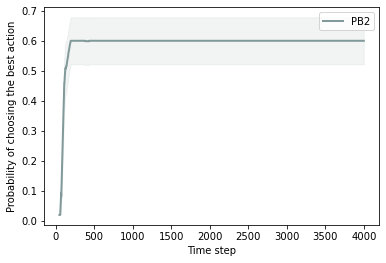

In [84]:
# Apply moving average
mean_smooth_PB2 = moving_average(mean_PB2, window_size)
std_dev_smooth_PB2 = moving_average(std_dev_PB2, window_size)

# Calculate the 95% confidence interval for smoothed data
conf_interval_smooth_PB2 = 1.96 * std_dev_smooth_PB2 / np.sqrt(window_size)

x_values_smooth_PB2 = range(window_size - 1, len(mean_PB2))

# Plot the mean and the confidence interval
plt.plot(x_values_smooth_PB2, mean_smooth_PB2, label='PB2' ,lw=2,ls='-', color= '#819999')
plt.fill_between(x_values_smooth_PB2, (mean_smooth_PB2-conf_interval_smooth_PB2), (mean_smooth_PB2+conf_interval_smooth_PB2), color='#819999', alpha=.1)

plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()


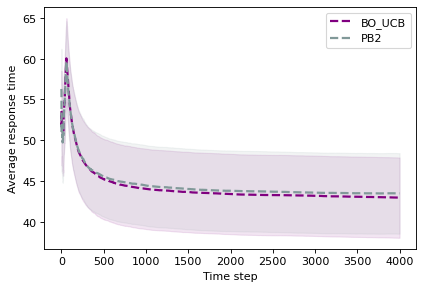

In [85]:
plt.figure(1,dpi=80)
plt.plot(BO_ucb,label='BO_UCB' ,lw=2,ls='--', color= 'purple')
plt.fill_between(np.arange(len(BO_ucb)), (BO_ucb - CI_P),(BO_ucb + CI_P),color= 'purple', alpha=0.1 )
plt.plot(PB2_m,label='PB2' ,lw=2,ls='--', color= '#819999')
plt.fill_between(np.arange(len(PB2_m)), (PB2_m - CI_PB2),(PB2_m + CI_PB2),color= '#819999', alpha=0.1 )
plt.xlabel("Time step")
plt.ylabel("Average response time")
#plt.title("UCB1 Simulation")
plt.legend()
plt.show()

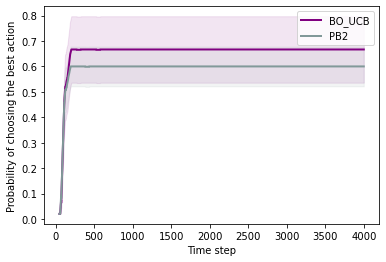

In [86]:
# Plot the mean and the confidence interval
plt.plot(x_values_smooth_P, mean_smooth_P, label='BO_UCB' ,lw=2,ls='-', color= 'purple')
plt.fill_between(x_values_smooth_P, (mean_smooth_P-conf_interval_smooth_P), (mean_smooth_P+conf_interval_smooth_P), color='purple', alpha=.1)
plt.plot(x_values_smooth_PB2, mean_smooth_PB2, label='PB2' ,lw=2,ls='-', color= '#819999')
plt.fill_between(x_values_smooth_PB2, (mean_smooth_PB2-conf_interval_smooth_PB2), (mean_smooth_PB2+conf_interval_smooth_PB2), color='#819999', alpha=.1)

plt.xlabel("Time step")
plt.ylabel("Probability of choosing the best action")
plt.legend()
plt.show()

## Normal UCB1

100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


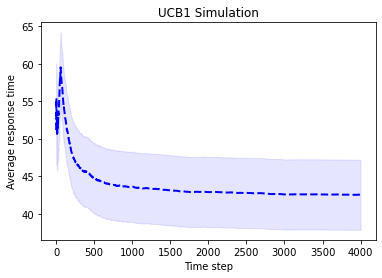

In [92]:

def run_ucb1_simulation(n_runs=1, n_steps=4000, c=1):
    average_response_times = []

    for run in tqdm(range(n_runs)):
        env = Env(mus, sigmas)
        select_action_class = UCB1(actions=num_actions, c=c)

        results = do_run(env, select_action_class, n_steps)
        average_response_times.append(results["average_response_time"])

    return np.array(average_response_times)

n_runs = 3
c = 1
average_response_times_ucb = run_ucb1_simulation(n_runs=n_runs, c=c)


CI_normal= 1.96 * np.std(average_response_times_ucb)/np.sqrt(len(average_response_times_ucb))
normal_ucb = average_response_times_ucb.mean(axis=0)
plt.plot(normal_ucb,label='Norm_UCB' ,lw=2,ls='--', color= 'blue')
plt.fill_between(np.arange(len(normal_ucb)), (normal_ucb - CI_normal),(normal_ucb + CI_normal),color= 'blue', alpha=0.1 )

plt.xlabel("Time step")
plt.ylabel("Average response time")
plt.title("UCB1 Simulation")
plt.show()


## Bootstrapped UCB

100%|██████████| 1/1 [01:18<00:00, 78.42s/it]


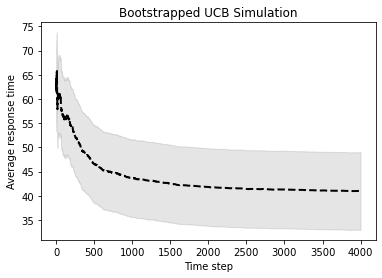

In [88]:

def run_bootstrapped_ucb_simulation(n_runs=1, n_steps=4000):
    average_response_times = []

    for run in tqdm(range(n_runs)):
        env = Env(mus, sigmas)
        select_action_class = BootstrappedUCB(actions = num_actions)

        results = do_run(env, select_action_class, n_steps)
        average_response_times.append(results["average_response_time"])

    return np.array(average_response_times)

n_runs = 1
average_response_times_boot = run_bootstrapped_ucb_simulation(n_runs=n_runs)


CI_boot= 1.96 * np.std(average_response_times_boot)/np.sqrt(len(average_response_times_boot))
boot_ucb = average_response_times_boot.mean(axis=0)
plt.plot(boot_ucb,label='Boots_UCB' ,lw=2,ls='--', color= 'black')
plt.fill_between(np.arange(len(boot_ucb)), (boot_ucb - CI_boot),(boot_ucb + CI_boot),color= 'black', alpha=0.1 )
plt.xlabel("Time step")
plt.ylabel("Average response time")
plt.title("Bootstrapped UCB Simulation")
plt.show()


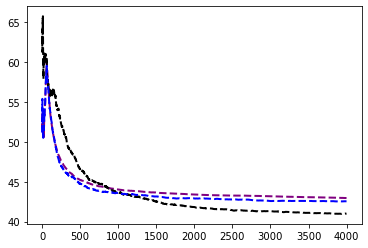

In [95]:
plt.plot(BO_ucb,label='BO_UCB' ,lw=2,ls='--', color= 'purple')
plt.plot(boot_ucb,label='Boots_UCB' ,lw=2,ls='--', color= 'black')
plt.plot(normal_ucb,label='Norm_UCB' ,lw=2,ls='--', color= 'blue')

## Thompson Sampling

100%|██████████| 3/3 [00:07<00:00,  2.53s/it]


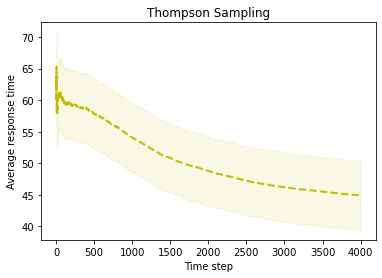

In [90]:
def run_thompson_simulation(n_runs=1, n_steps=4000):
    average_response_times = []

    for run in tqdm(range(n_runs)):
        env = Env(mus, sigmas)
        select_action_class = ThompsonSamplingUnknownMeanVariance(actions=num_actions)

        results = do_run(env, select_action_class, n_steps)
        average_response_times.append(results["average_response_time"])

    return np.array(average_response_times)

n_runs = 3
average_response_times_thom = run_thompson_simulation(n_runs=n_runs)
CI_tm= 1.96 * np.std(average_response_times_thom)/np.sqrt(len(average_response_times_thom))
TM = average_response_times_thom.mean(axis=0)
plt.plot(TM,label='TS' ,lw=2,ls='--', color= 'y')
plt.fill_between(np.arange(len(TM)), (TM - CI_tm),(TM + CI_tm),color= 'y', alpha=0.1 )
plt.xlabel("Time step")
plt.ylabel("Average response time")
plt.title("Thompson Sampling")
plt.show()
